# Projeto facerecog

In [2]:
pacotes = !pip freeze

In [3]:
%%writefile requirements.txt

# lista extensa do environment, depois filtro para os que foram utilizados realmente
ipython==5.1.0
jupyter==1.0.0
matplotlib==1.5.3
notebook==4.2.3
numpy==1.11.2
pandas==0.18.1
Pillow==3.4.1
pytesseract==0.1.6
scikit-image==0.12.3
seaborn==0.7.1

# the following must be installed separately
# opencv==3.1.0
# tesseract

Overwriting requirements.txt


In [4]:
# uncomment line below to install requirements (recommended to use a virtualenv)
#!pip install -r requirements.txt

-----------------------

# Importação de pacotes

In [5]:
%matplotlib inline
""" handling files support packages """
from glob import glob

""" logic support packages """
import numpy as np
import pytesseract
import itertools
import csv

""" plot support packages """
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

""" image trasformation packages """
from PIL import Image
import skimage.io as skio
from skimage.util import dtype_limits
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.filters import rank
from skimage.measure import compare_ssim, compare_mse

""" statistical data visualization packages"""
import seaborn as sns

""" seaborn configurations """
sns.set_style('white')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = 20, 10


--------------------

## Funções de comparação entre imagens

In [6]:
def mse(imageA, imageB):
    """Função de compara entre duas imagens e retorna o erro médio quadrado
    entre as duas imagens.
    Nota: as imagens devem ter as mesmas dimensões"""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [7]:
def compare_images(imageA, imageB, title, channel=True):
    """Função para comparar duas imagens e plotar o resultado"""
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = compare_ssim(imageA, imageB, multichannel=channel)
 
    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

In [8]:
# function that returns mse and ssim
def comp_images(imageA, imageB, channel=True):
    """Função para comparar duas imagens e retornar os
    valores de mse e ssim em uma lista"""
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = compare_ssim(imageA, imageB, multichannel=channel)
    return [m, s]

---------------------------

# Funções de suporte

In [9]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [10]:
def plot_captchas(imgs, grid=(5, 4)):
    gs = gridspec.GridSpec(*grid)
    for idx, gspec in enumerate(gs):
        ax = plt.subplot(gspec)
        plt.imshow(imgs[idx])

In [11]:
def save_images(letter_dict):
    i=0
    
    with open('../letras.csv', 'w+') as f:
        f.write("path, rotulo, caixa_alta_baixa\n")
        
    for letra in letter_dict:
        for imagem in letter_dict[letra]:
            im = Image.fromarray(imagem)
            im.save("../letras/caracter" + str(i) + ".png")
            with open('../letras.csv', 'a+') as f:
                if letra.istitle():
                    f.write("letras/caracter" + str(i) + ".png, " + letra + ", maiusculo\n")
                else:
                    if letra.isdigit():
                        f.write("letras/caracter" + str(i) + ".png, " + letra + ", numero\n")
                    else:
                        f.write("letras/caracter" + str(i) + ".png, " + letra + ", minusculo\n")
            i = i + 1

In [12]:
def get_char(img, n_char):
    sw = {
        0: {'x1': 0, 'x2': 50, 'y1': 5, 'y2': 40},
        1: {'x1': 0, 'x2': 50, 'y1': 35, 'y2': 70},
        2: {'x1': 0, 'x2': 50, 'y1': 65, 'y2': 100},
        3: {'x1': 0, 'x2': 50, 'y1': 95, 'y2': 130},
        4: {'x1': 0, 'x2': 50, 'y1': 123, 'y2': 158},
        5: {'x1': 0, 'x2': 50, 'y1': 145, 'y2': 180},
    }
    return img[sw[n_char]['x1']:sw[n_char]['x2'], sw[n_char]['y1']:sw[n_char]['y2']]

In [13]:
def feed_char_dict(char_dict, letter_array, imgs):
    for letter, img in zip(letter_array, imgs):
    
        if letter in char_dict:
            char_dict[letter].append(img)
        else:
            char_dict[letter] = [img]

In [14]:
def ler_letras(file):
    """ Função para ler o arquivo letras.csv.
    Retorno duplo de uma lista de arquivos e um dicionário dos arquivos rótulo e caixa"""
    dic = {}
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            dic[row['path'].strip()] = {'rotulo':row[' rotulo'].strip(),
                                        'caixa':row[' caixa_alta_baixa'].strip()}
        return [list(dic.keys()), dic]

In [15]:
def checar_combinacoes(permuta, dic):
    """ Função que recebe a permutação de arquivos e dicionário com rótulos
    e retorna, em uma lista, as quantidades de permutações com rótulos iguais e
    a quantidade de permutações com rótulos diferentes."""
    mesmo = 0.
    diferentes = 0.
    for i in permuta:
        if (dic[i[0]]['rotulo'] == dic[i[1]]['rotulo']):
            mesmo = mesmo + 1
        else:
            diferentes = diferentes + 1
    return [mesmo, diferentes]

-----------------------------

## Filtro nas imagens

In [16]:
def remove_small_blobs(bw_img, min_area=10, **label_kwargs):
    """ Remove small blobs in the bw img. """
    labels = label(bw_img, **label_kwargs)

    # pick the background and foreground colors
    bg = label_kwargs.get('background', 0) 
    fg = dtype_limits(bw_img, clip_negative=True)[1] - bg

    # create an empty image
    new_bw = np.ones_like(bw_img) * bg
    
    # check the area of each region
    for roi in regionprops(labels):
        if roi.area >= min_area:
            new_bw[labels == roi.label] = fg

    return new_bw

---------------------------

## Teste do PyTesseract

In [17]:
def run_tesseract(imgs):
    """Aplica a função image_to_string da biblioteca pytesseract
    em um vetor de funções. O que imprime a String encontrada."""
    for img in imgs:
        img = Image.fromarray( img )
        print( pytesseract.image_to_string( img ) )

----------------------------

# Leitura das imagens iniciais funções de suporte

In [18]:
img_files = sorted(glob('../imagens/captcha*.png'))
print(img_files)
imgs = skio.imread_collection(img_files)
print(imgs.files)

['../imagens/captcha1.png', '../imagens/captcha10.png', '../imagens/captcha11.png', '../imagens/captcha12.png', '../imagens/captcha13.png', '../imagens/captcha14.png', '../imagens/captcha15.png', '../imagens/captcha16.png', '../imagens/captcha17.png', '../imagens/captcha18.png', '../imagens/captcha19.png', '../imagens/captcha2.png', '../imagens/captcha20.png', '../imagens/captcha3.png', '../imagens/captcha4.png', '../imagens/captcha5.png', '../imagens/captcha6.png', '../imagens/captcha7.png', '../imagens/captcha8.png', '../imagens/captcha9.png']
['../imagens/captcha1.png', '../imagens/captcha10.png', '../imagens/captcha11.png', '../imagens/captcha12.png', '../imagens/captcha13.png', '../imagens/captcha14.png', '../imagens/captcha15.png', '../imagens/captcha16.png', '../imagens/captcha17.png', '../imagens/captcha18.png', '../imagens/captcha19.png', '../imagens/captcha2.png', '../imagens/captcha20.png', '../imagens/captcha3.png', '../imagens/captcha4.png', '../imagens/captcha5.png', '../

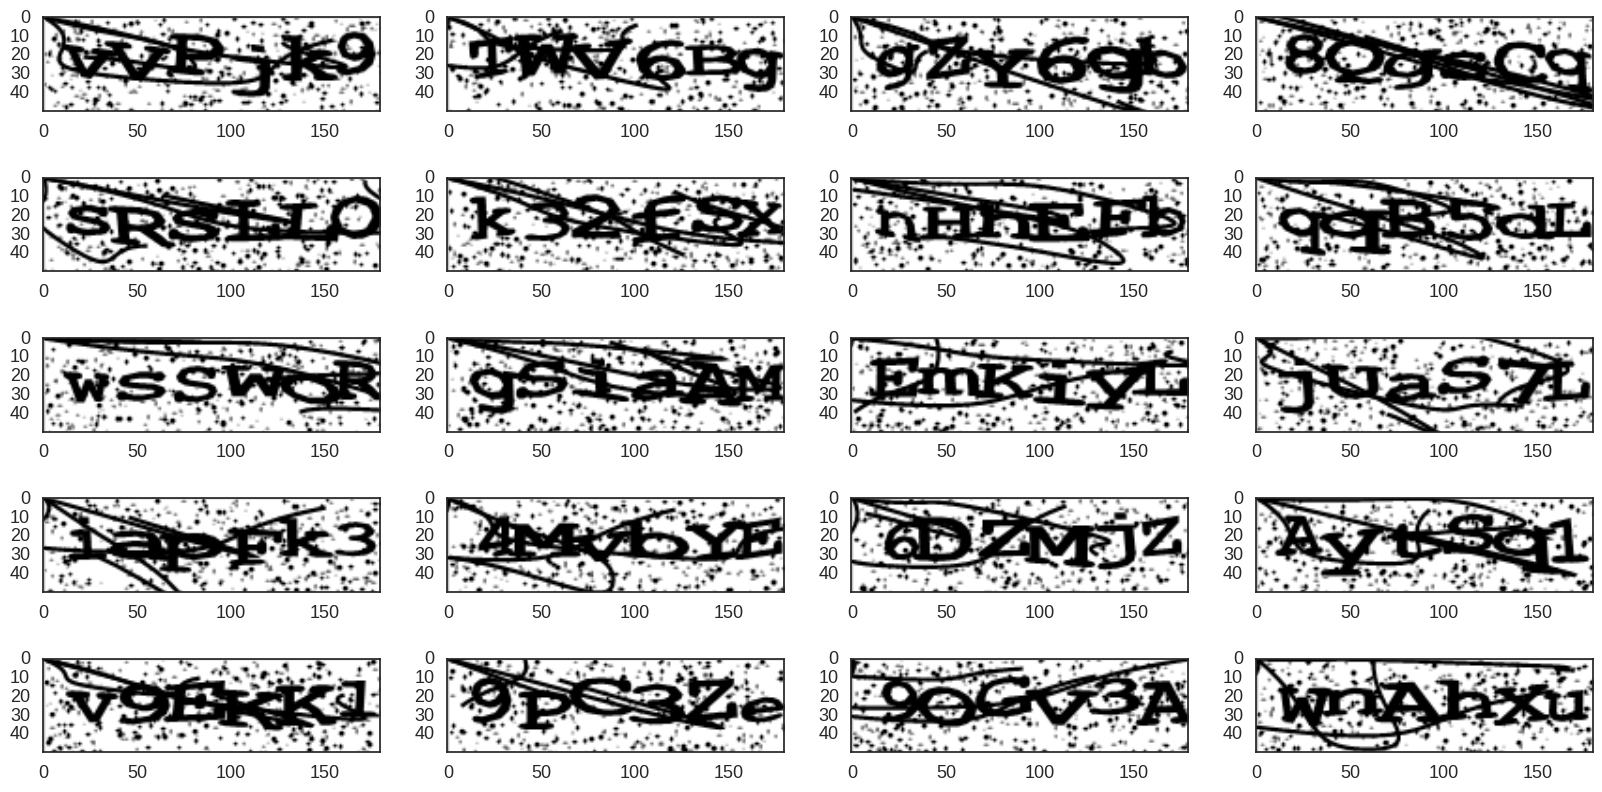

In [19]:
plot_captchas(imgs)

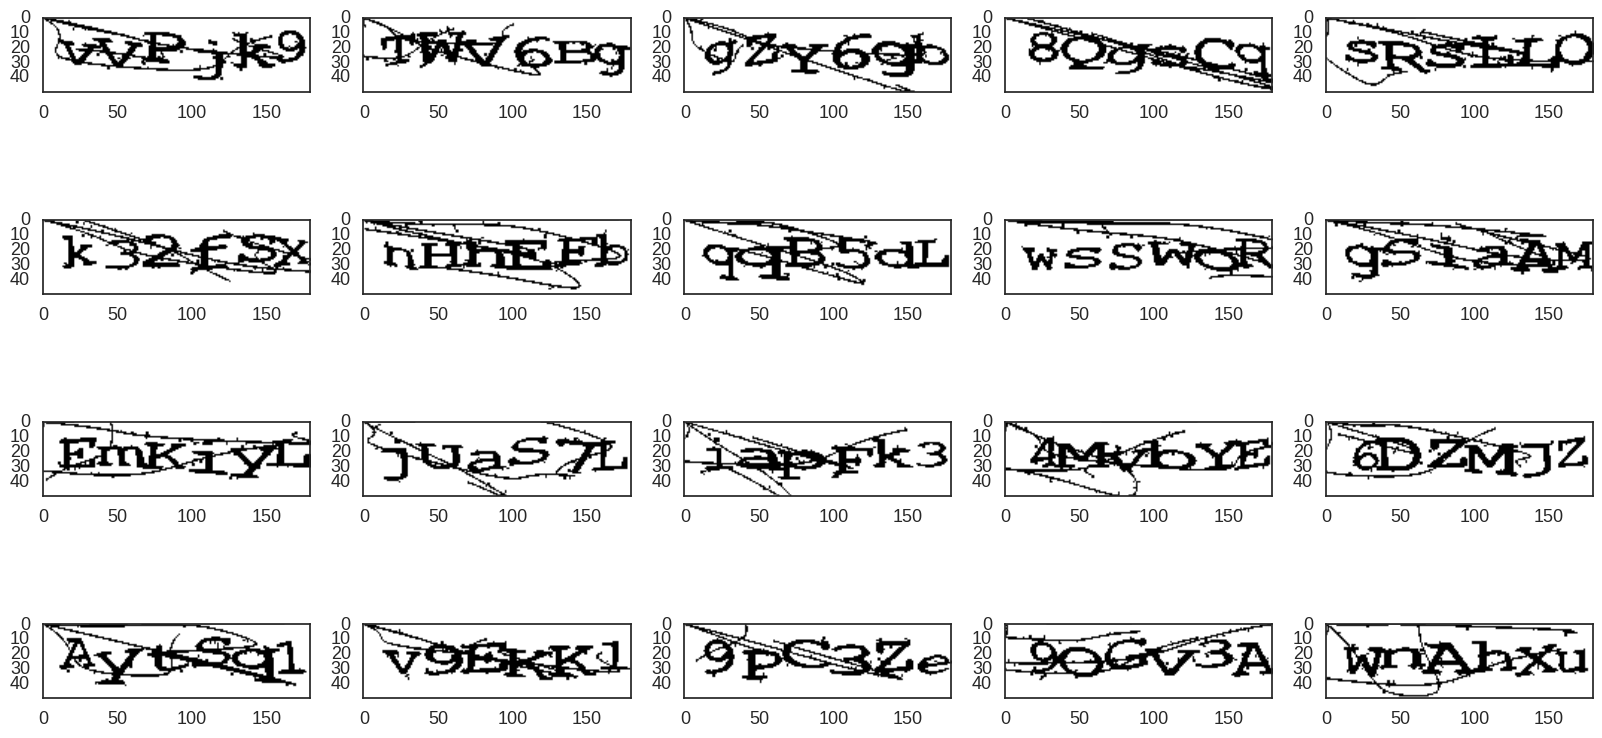

In [20]:
unblobbed = [remove_small_blobs(img, min_area=50, background=255) for img in imgs]
plot_captchas(unblobbed, (4, 5))

------------------------

# Extração e arquivo das letras dos primeiros captchas

In [21]:
captcha_letters = dict()
captcha_letters.clear()
print(captcha_letters == {})

True


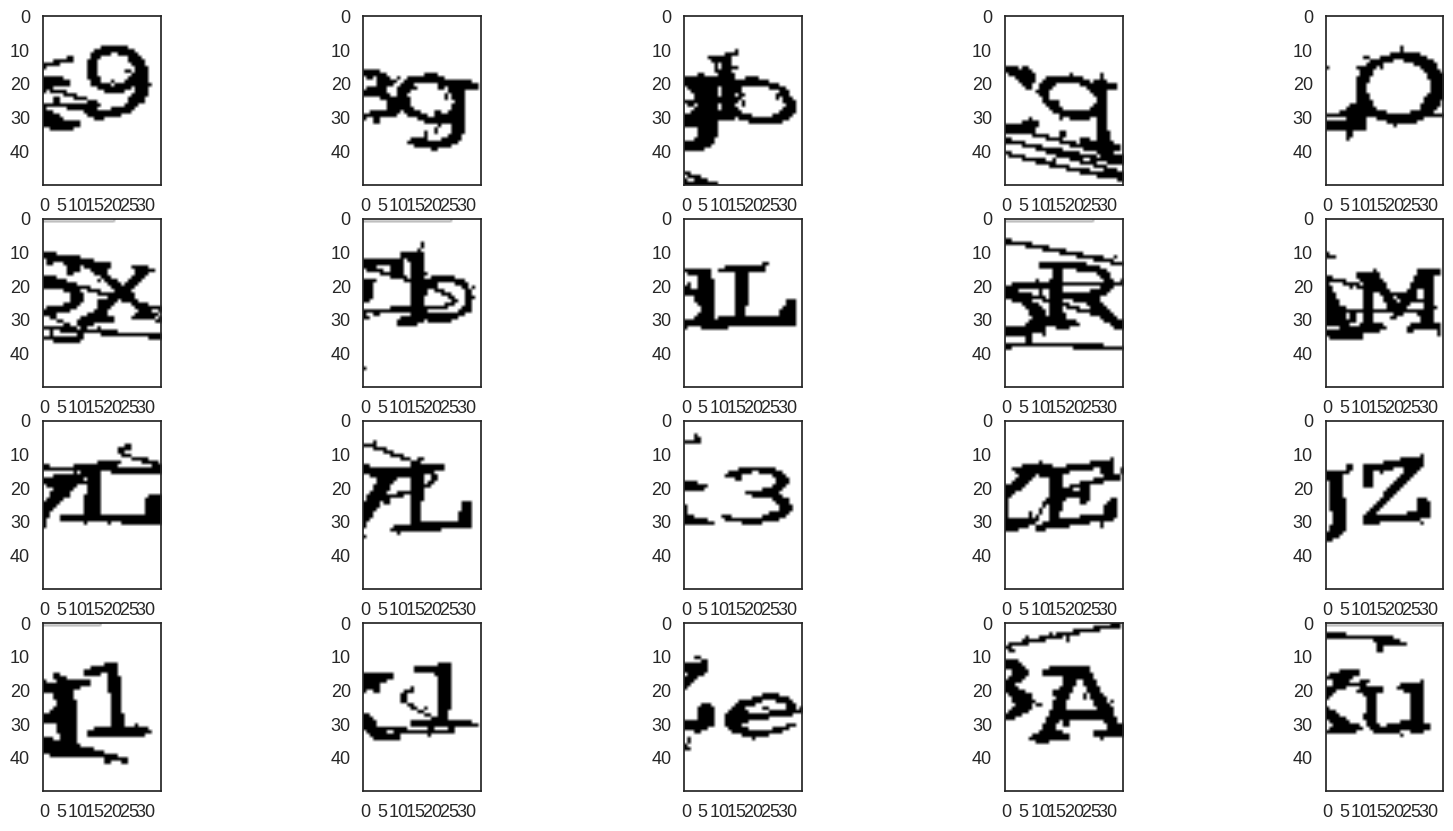

In [22]:
# 6º caractere
cropped = [get_char(img, 5) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [23]:
letters = ('9', 'g', 'b', 'q', 'O',
           'x', 'b', 'L', 'R', 'M',
           'L', 'L', '3', 'E', 'Z',
           '1', '1', 'e', 'A', 'u')

feed_char_dict(captcha_letters, letters, cropped)

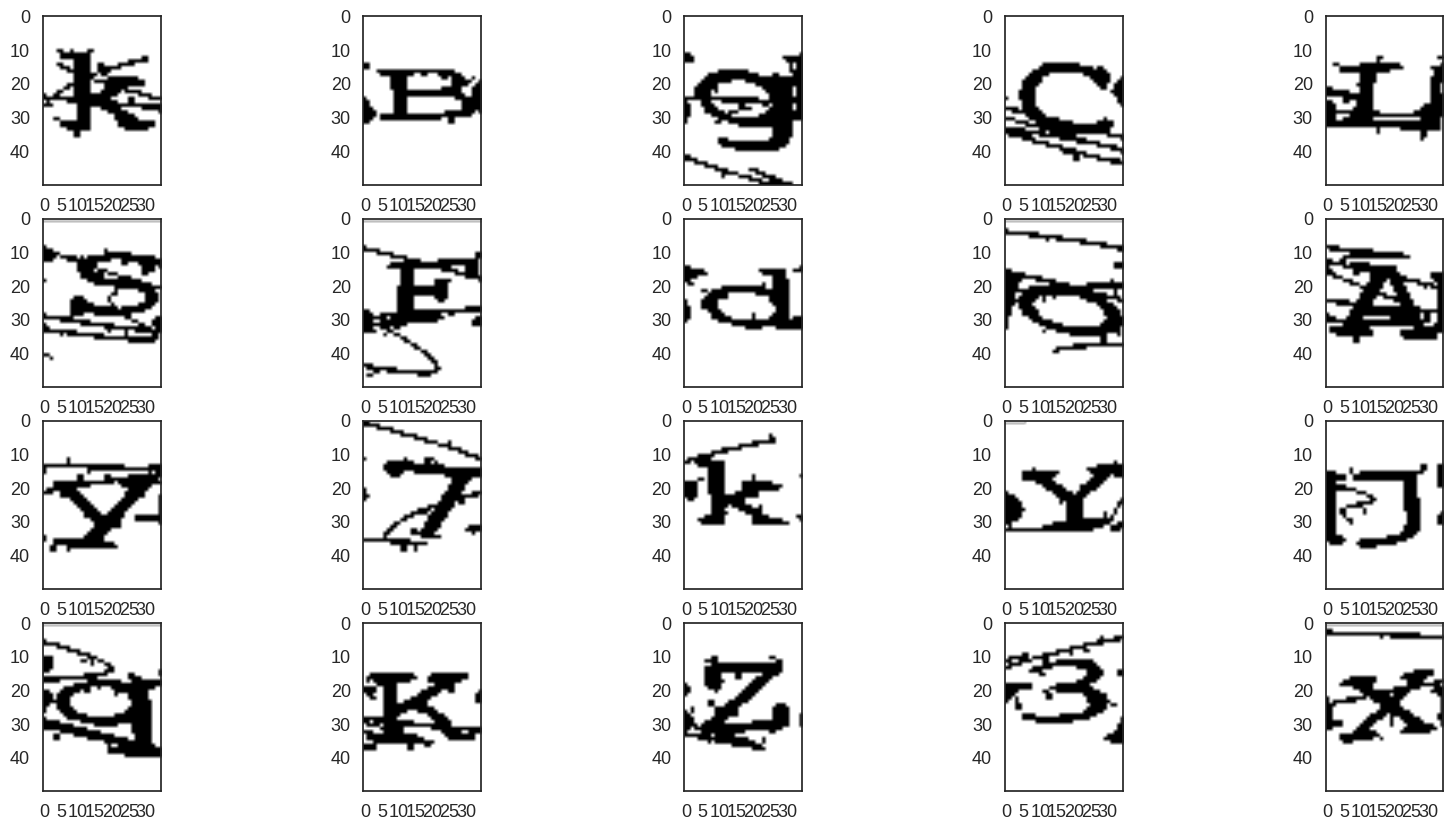

In [24]:
# 5º caractere
cropped = [get_char(img, 4) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [25]:
letters = ('k', 'b', 'g', 'c', 'L',
           'S', 'F', 'd', 'o', 'A',
           'y', '7', 'k', 'Y', 'J',
           'q', 'K', 'Z', '3', 'X')

feed_char_dict(captcha_letters, letters, cropped)

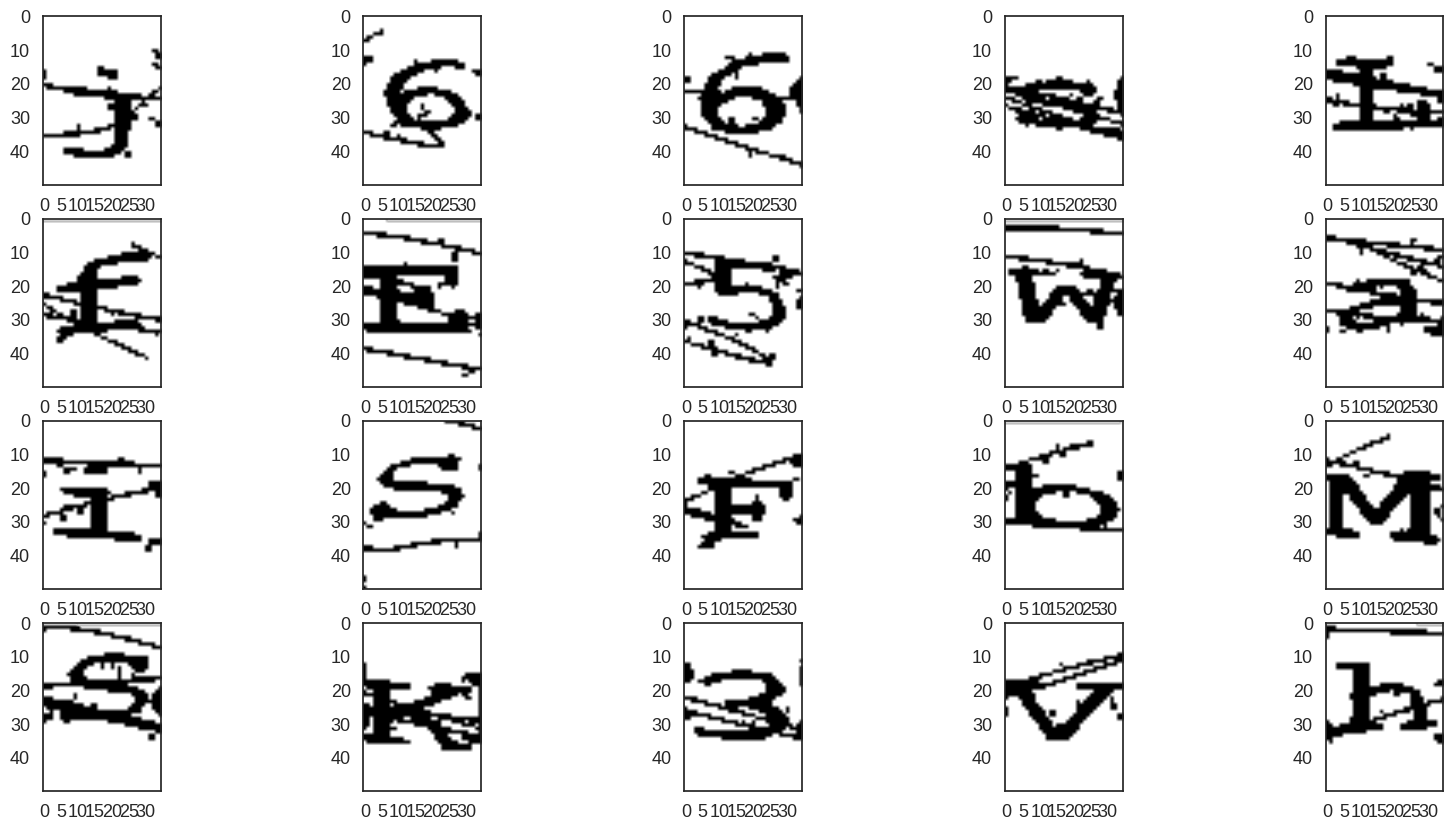

In [26]:
# 4º caractere
cropped = [get_char(img, 3) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [27]:
letters = ('j', '6', '6', 's', 'L',
           'f', 'E', '5', 'W', 'a',
           'i', 'S', 'F', 'b', 'M',
           'S', 'K', '3', 'V', 'h')

feed_char_dict(captcha_letters, letters, cropped)

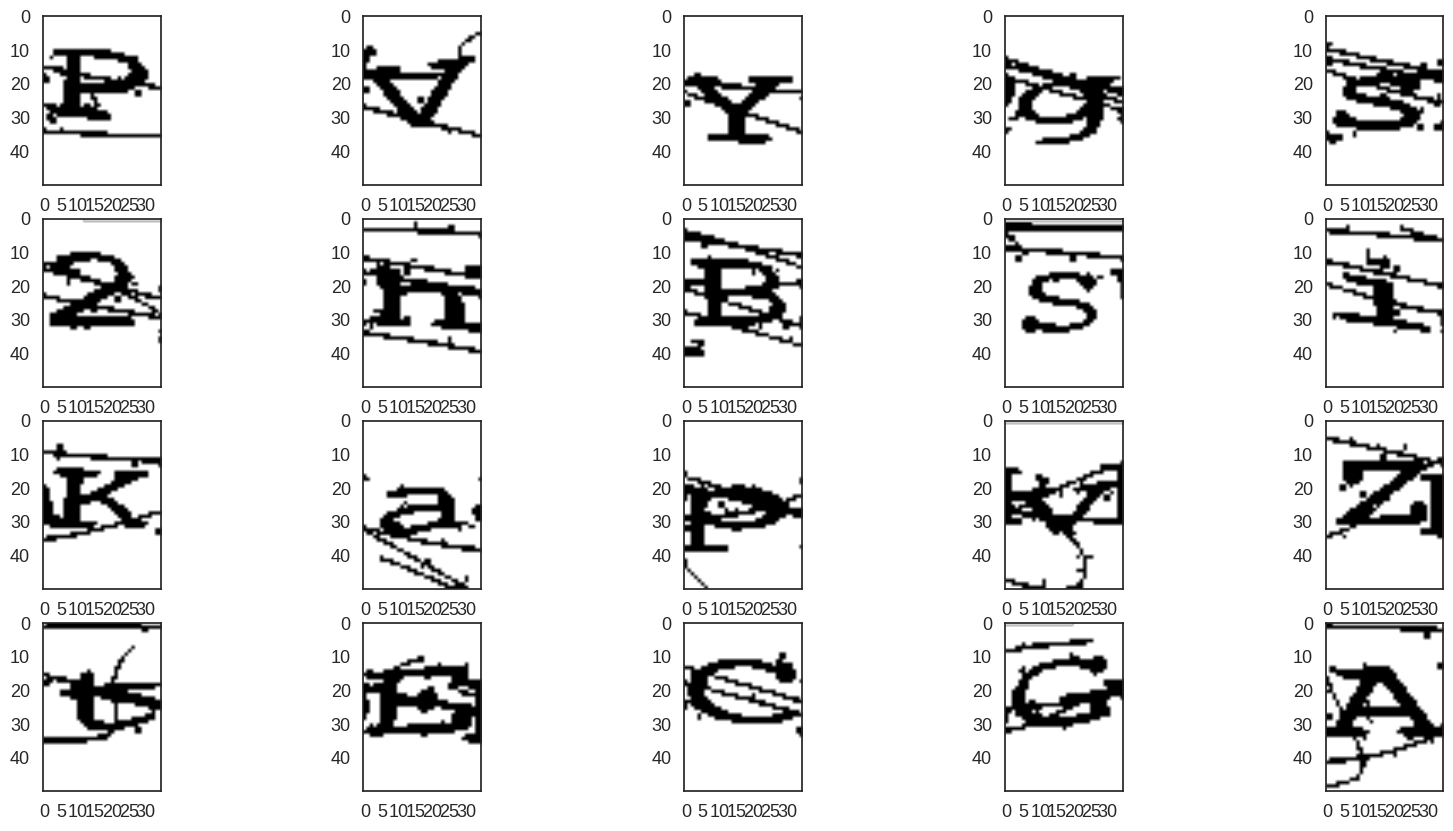

In [28]:
# 3º caractere
cropped = [get_char(img, 2) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [29]:
letters = ('P', 'V', 'Y', 'g', 's',
           '2', 'n', 'B', 's', 'i',
           'K', 'a', 'p', 'v', 'Z',
           't', 'E', 'C', 'G', 'A')

feed_char_dict(captcha_letters, letters, cropped)

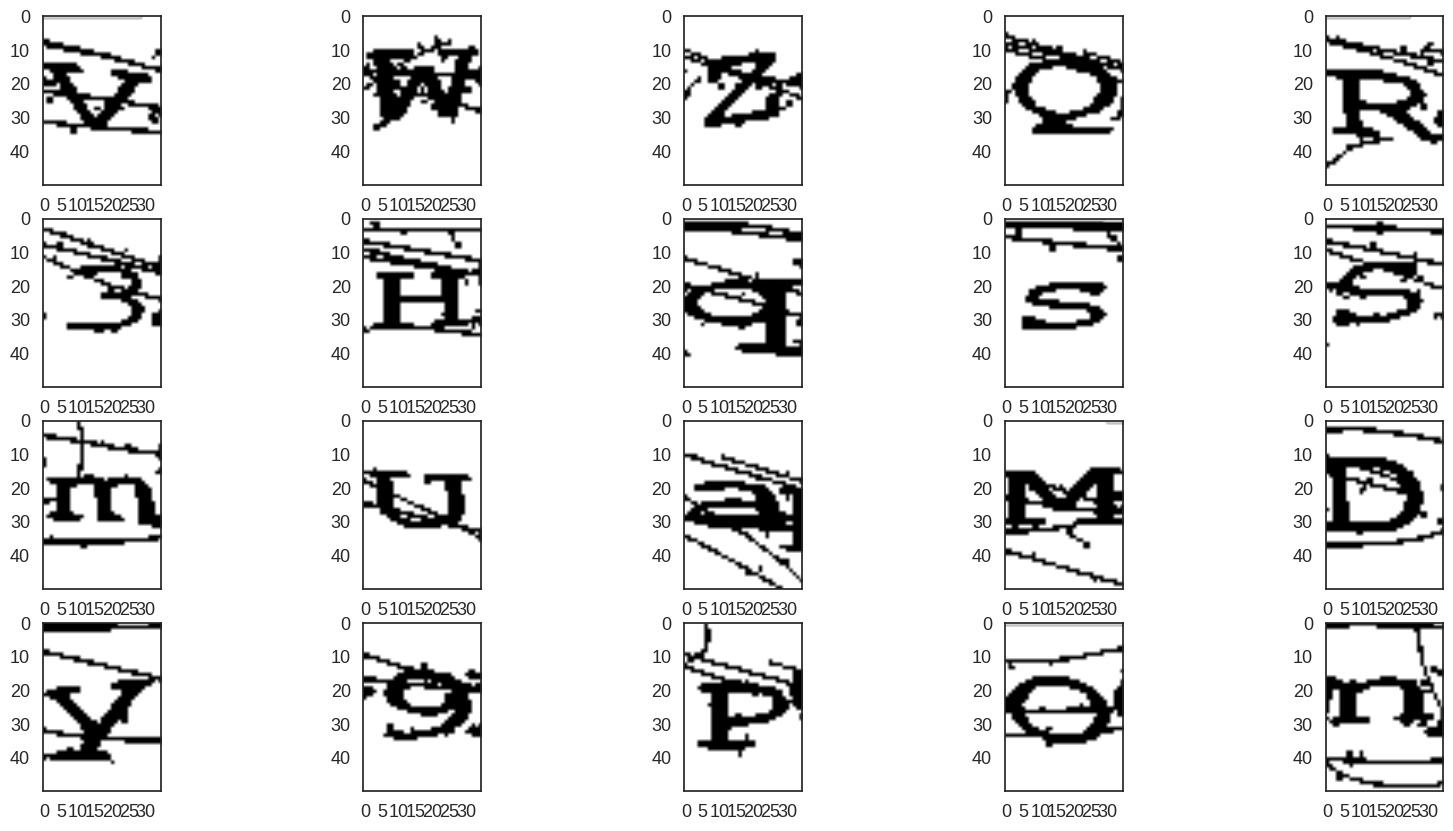

In [30]:
# 2º caractere
cropped = [get_char(img, 1) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [31]:
letters = ('V', 'W', 'Z', 'Q', 'R',
           '3', 'H', 'q', 's', 'S',
           'm', 'u', 'a', 'M', 'D',
           'y', '9', 'p', 'o', 'n')

feed_char_dict(captcha_letters, letters, cropped)

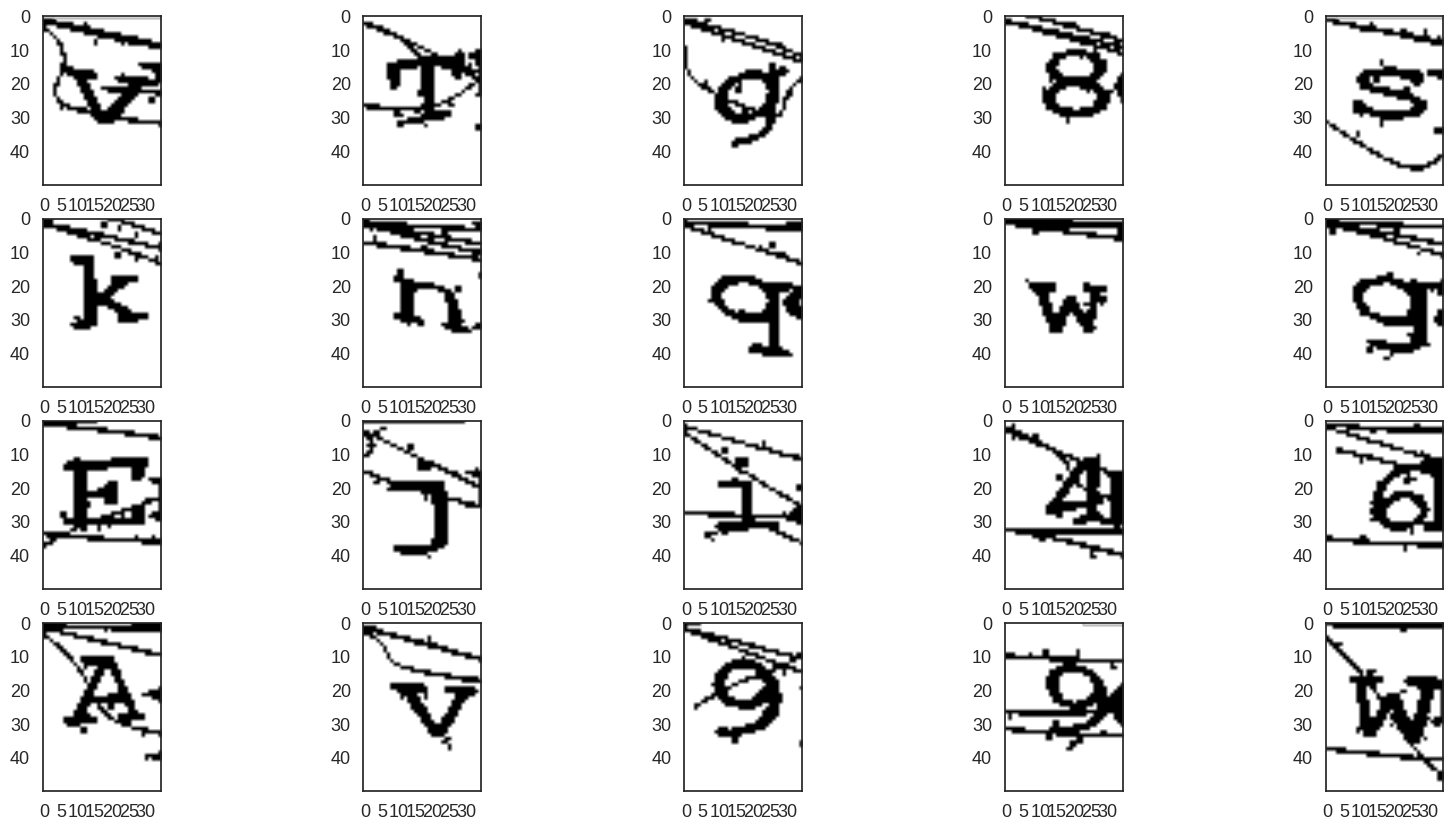

In [32]:
# 1º caractere
cropped = [get_char(img, 0) for img in unblobbed ]
plot_captchas( cropped, (4, 5) )

In [33]:
letters = ('v', 'T', 'g', '8', 's',
           'k', 'n', 'q', 'w', 'g',
           'E', 'j', 'i', '4', '6',
           'A', 'v', '9', '9', 'W')

feed_char_dict(captcha_letters, letters, cropped)

----------

# Inclusão dos novos captchas

À partir daqui farei a inclusão dos novos captchas no dicionário já criado **captcha_letters**:

In [34]:
img_files = sorted(glob('../imagens/gerarCaptcha.asp*.png'))
print(img_files)
imgs = skio.imread_collection(img_files)

['../imagens/gerarCaptcha.asp.png', '../imagens/gerarCaptcha.asp1.png', '../imagens/gerarCaptcha.asp10.png', '../imagens/gerarCaptcha.asp11.png', '../imagens/gerarCaptcha.asp12.png', '../imagens/gerarCaptcha.asp13.png', '../imagens/gerarCaptcha.asp14.png', '../imagens/gerarCaptcha.asp15.png', '../imagens/gerarCaptcha.asp16.png', '../imagens/gerarCaptcha.asp17.png', '../imagens/gerarCaptcha.asp18.png', '../imagens/gerarCaptcha.asp19.png', '../imagens/gerarCaptcha.asp2.png', '../imagens/gerarCaptcha.asp20.png', '../imagens/gerarCaptcha.asp21.png', '../imagens/gerarCaptcha.asp22.png', '../imagens/gerarCaptcha.asp23.png', '../imagens/gerarCaptcha.asp24.png', '../imagens/gerarCaptcha.asp25.png', '../imagens/gerarCaptcha.asp26.png', '../imagens/gerarCaptcha.asp27.png', '../imagens/gerarCaptcha.asp28.png', '../imagens/gerarCaptcha.asp29.png', '../imagens/gerarCaptcha.asp3.png', '../imagens/gerarCaptcha.asp30.png', '../imagens/gerarCaptcha.asp31.png', '../imagens/gerarCaptcha.asp32.png', '../i

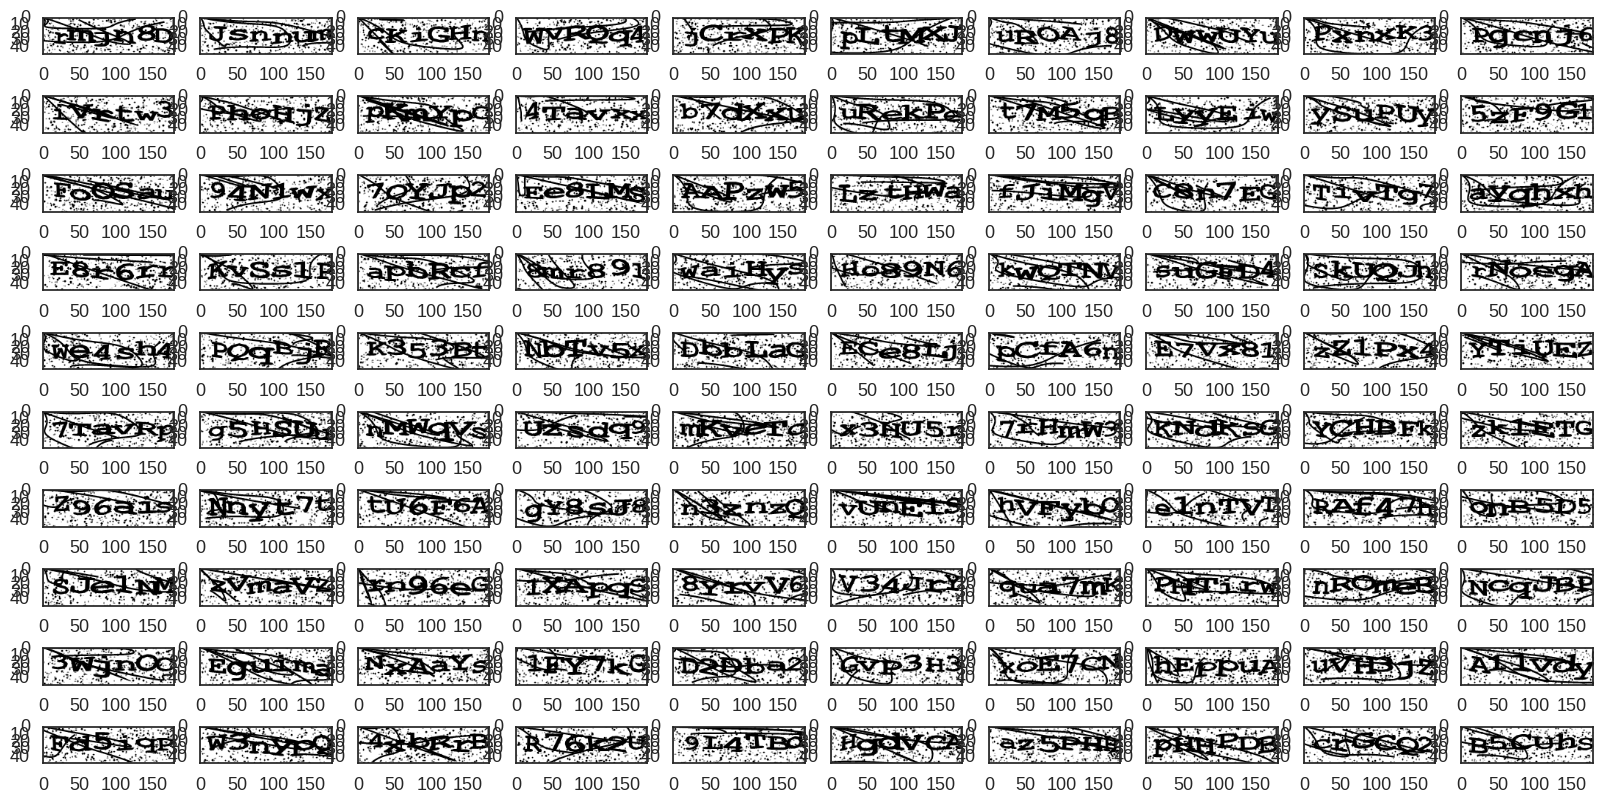

In [35]:
plot_captchas(imgs, (10, 10))

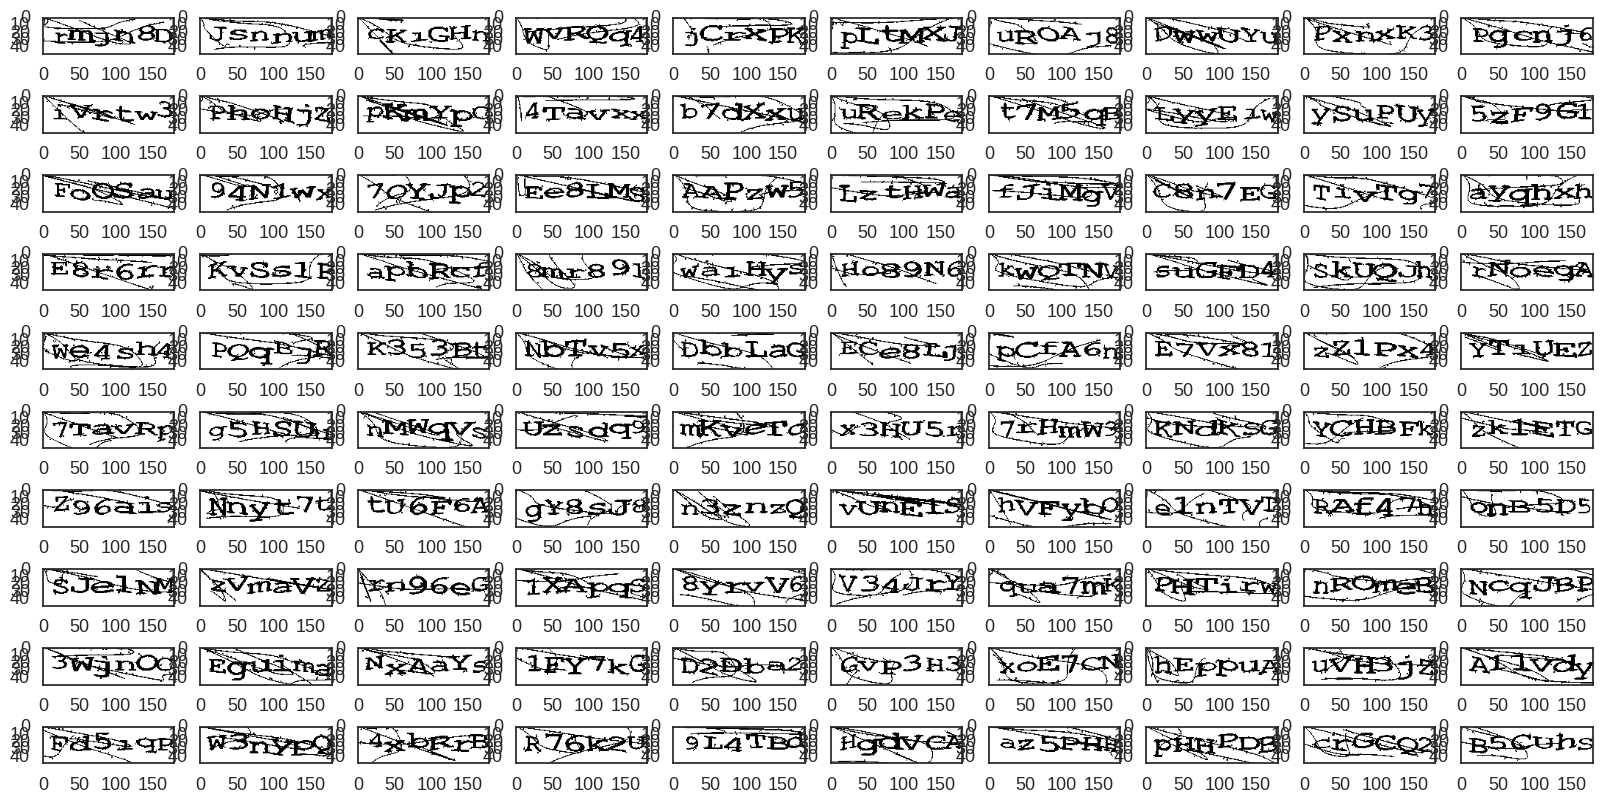

In [36]:
unblobbed = [remove_small_blobs(img, min_area=50, background=255) for img in imgs]
plot_captchas(unblobbed, (10, 10))

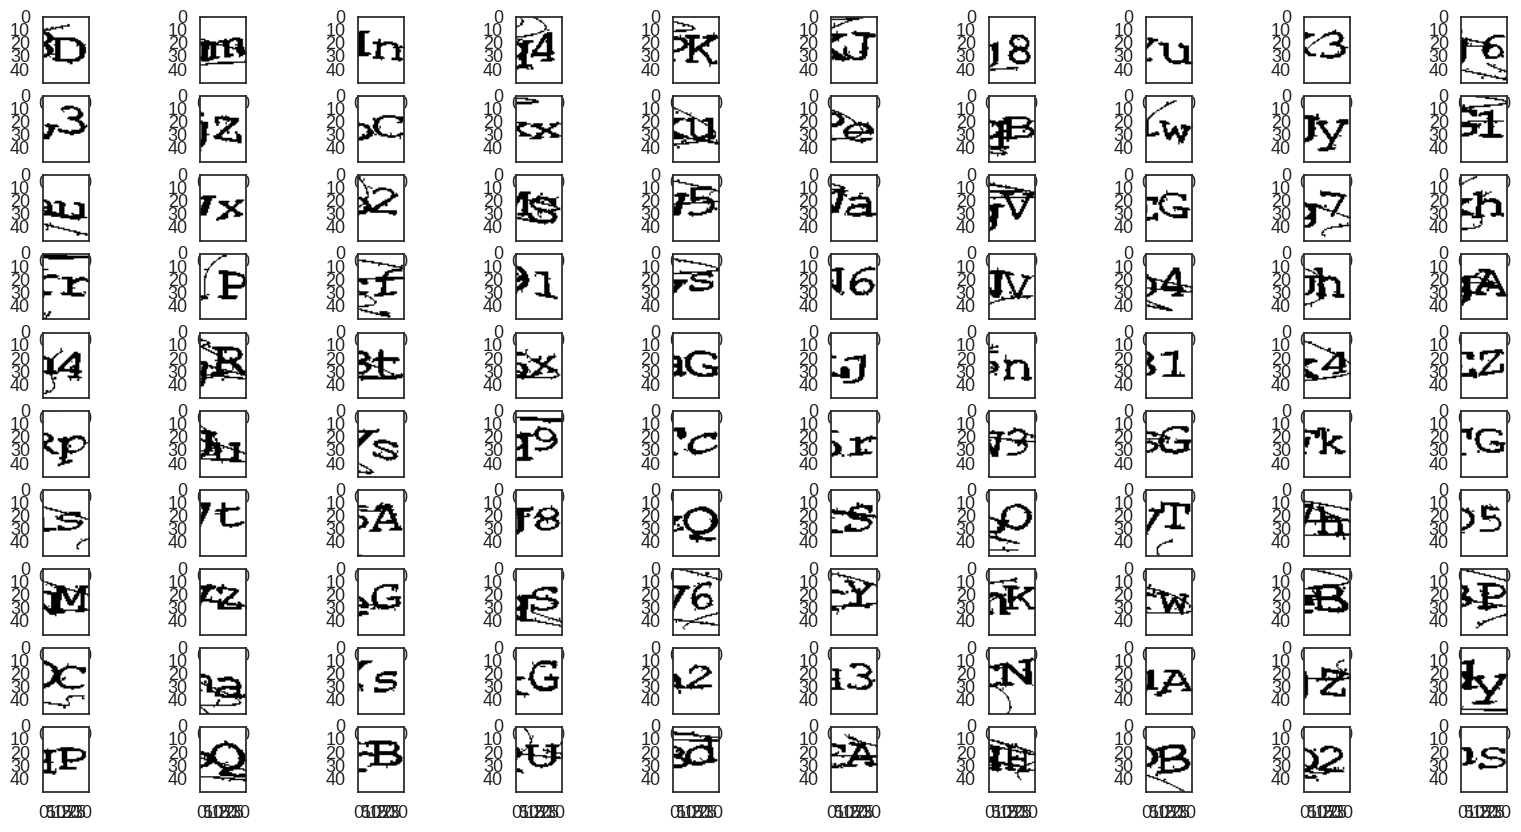

In [37]:
# 6º caractere
cropped = [get_char(img, 5) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [38]:
letters = ('D', 'M', 'n', '4', 'K', 'J', '8', 'u', '3', '6',
            '3', 'z', 'c', 'x', 'u', 'e', 'B', 'w', 'y', '1',
            'u', 'x', '2', 's', '5', 'a', 'V', 'G', '7', 'h',
            'r', 'P', 'f', '1', 's', '6', 'V', '4', 'h', 'A',
            '4', 'R', 't', 'x', 'G', 'j', 'n', '1', '4', 'Z',
            'p', 'u', 's', '9', 'c', 'r', '3', 'G', 'k', 'G',
            's', 't', 'A', '8', 'Q', 'S', 'O', 'T', 'h', '5',
            'M', 'z', 'G', 's', '6', 'Y', 'K', 'w', 'B', 'P',
            'C', 'a', 's', 'G', '2', '3', 'N', 'A', 'Z', 'y',
            'p', 'Q', 'B', 'U', 'd', 'A', 'H', 'B', '2', 's')

feed_char_dict(captcha_letters, letters, cropped)

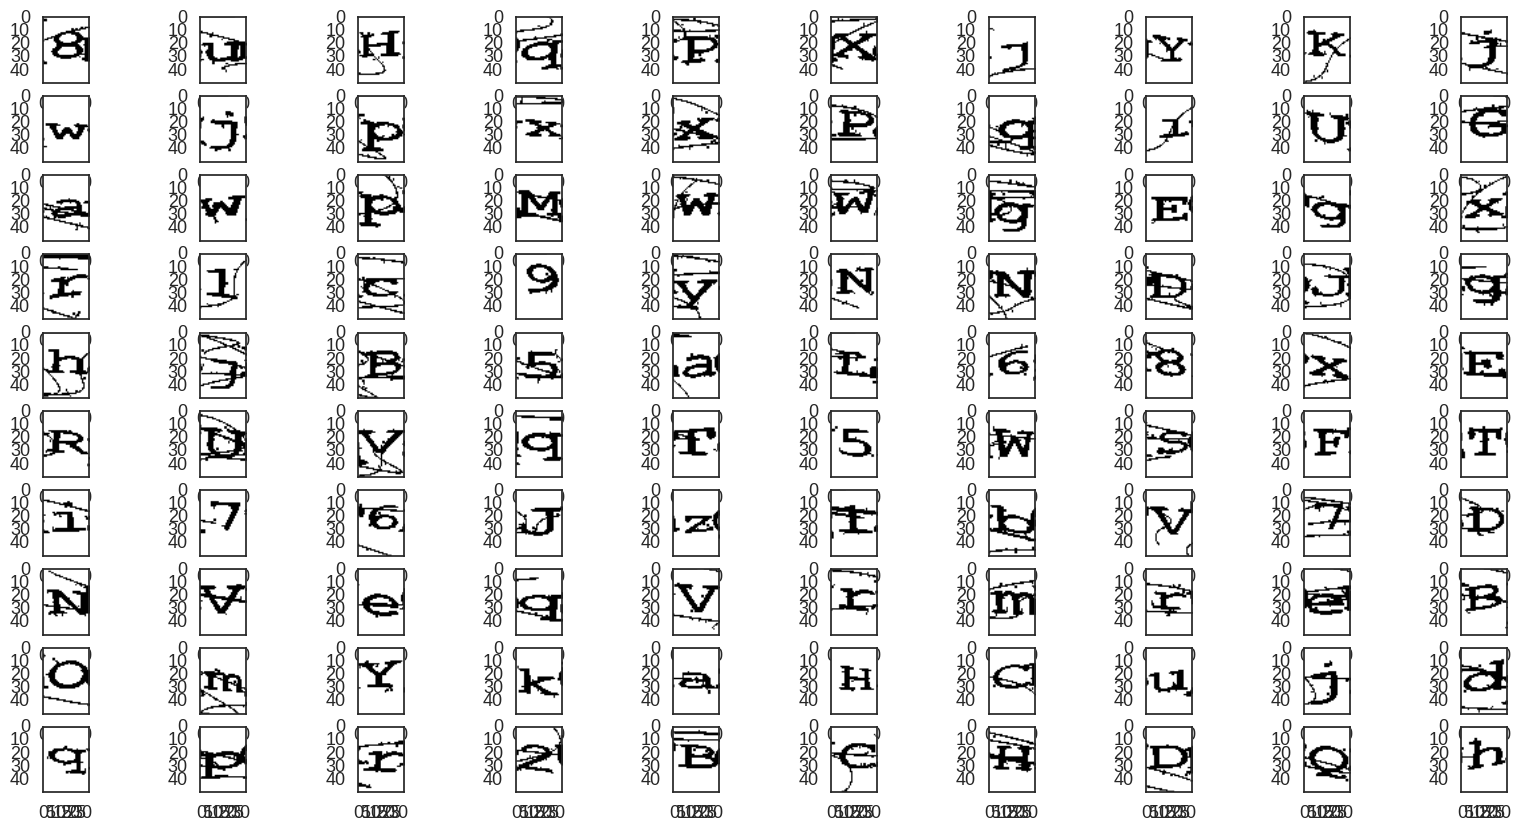

In [39]:
# 5º caractere
cropped = [get_char(img, 4) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [40]:
letters = ('8', 'u', 'H', 'q', 'P', 'X', 'j', 'Y', 'K', 'j',
            'w', 'j', 'p', 'x', 'x', 'P', 'q', '1', 'U', 'G',
            'a', 'w', 'p', 'M', 'w', 'w', 'g', 'E', 'g', 'x',
            'r', '1', 'c', '9', 'y', 'N', 'N', 'D', 'J', 'g',
            'h', 'j', 'B', '5', 'a', 'L', '6', '8', 'x', 'E',
            'R', 'U', 'V', 'q', 'T', '5', 'W', 's', 'F', 'T',
            'i', '7', '6', 'J', 'z', '1', 'b', 'V', '7', 'D',
            'N', 'V', 'e', 'q', 'V', 'r', 'm', 'r', 'e', 'B',
            'O', 'm', 'Y', 'k', 'a', 'H', 'C', 'u', 'j', 'd',
            'q', 'p', 'r', '2', 'B', 'c', 'H', 'D', 'Q', 'h')

feed_char_dict(captcha_letters, letters, cropped)

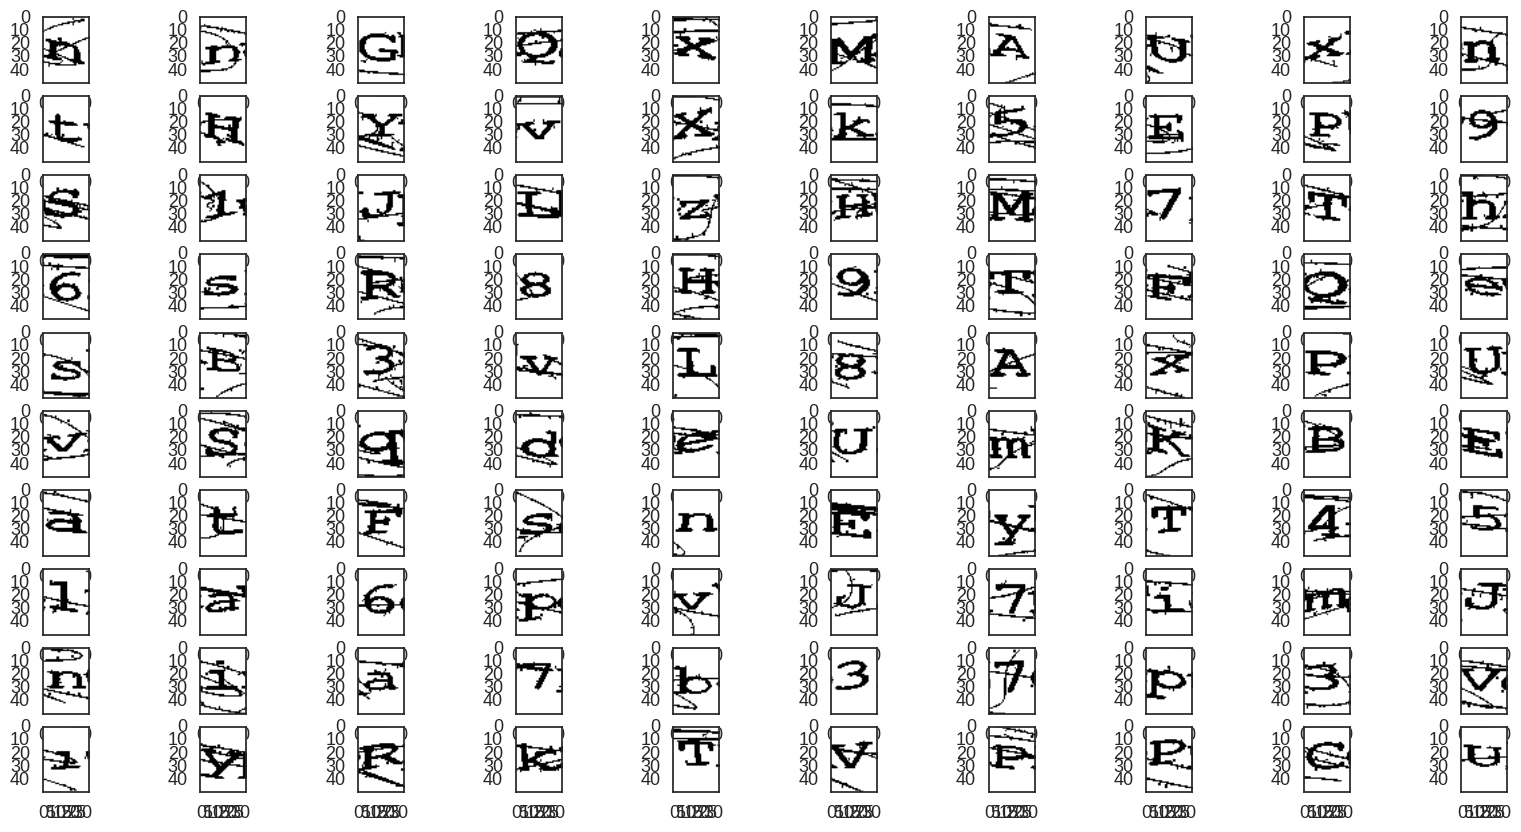

In [41]:
# 4º caractere
cropped = [get_char(img, 3) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [42]:
letters = ('n', 'n', 'G', 'Q', 'x', 'M', 'A', 'U', 'x', 'n',
            't', 'H', 'Y', 'v', 'X', 'k', '5', 'E', 'P', '9',
            'S', '1', 'J', 'L', 'z', 'H', 'M', '7', 'T', 'h',
            '6', 's', 'R', '8', 'H', '9', 'T', 'F', 'Q', 'e',
            's', 'B', '3', 'v', 'L', '8', 'A', 'x', 'P', 'U',
            'v', 'S', 'q', 'd', 'e', 'U', 'm', 'K', 'B', 'E',
            'a', 't', 'F', 's', 'n', 'E', 'y', 'T', '4', '5',
            'l', 'a', '6', 'p', 'v', 'J', '7', 'i', 'm', 'J',
            'n', 'i', 'a', '7', 'b', '3', '7', 'p', '3', 'v',
            '1', 'y', 'R', 'k', 'T', 'V', 'p', 'p', 'C', 'u')

feed_char_dict(captcha_letters, letters, cropped)

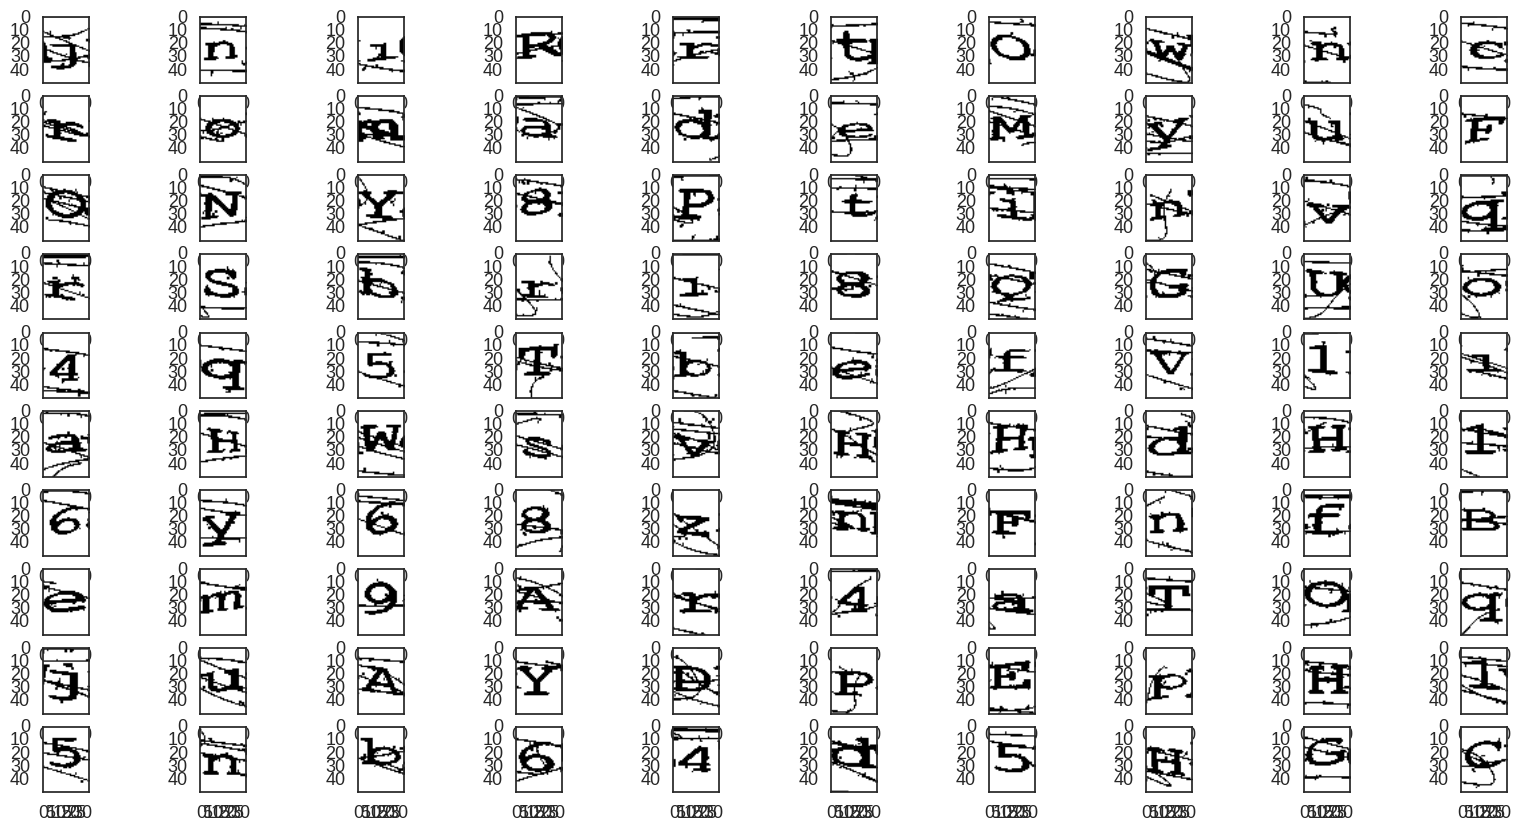

In [43]:
# 3º caractere
cropped = [get_char(img, 2) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [44]:
letters = ('j', 'n', '1', 'R', 'r', 't', 'O', 'w', 'n', 'c',
          'r', 'o', 'm', 'a', 'd', 'e', 'M', 'y', 'u', 'F',
          'O', 'N', 'Y', '8', 'P', 't', 'i', 'n', 'v', 'q',
          'r', 'S', 'b', 'r', '1', '8', 'Q', 'G', 'U', 'o',
          '4', 'q', '5', 'T', 'b', 'e', 'f', 'V', '1', '1',
          'a', 'H', 'W', 's', 'v', 'H', 'H', 'd', 'H', '1',
          '6', 'y', '6', '8', 'z', 'n', 'F', 'n', 'f', 'B',
          'e', 'm', '9', 'A', 'r', '4', 'a', 'T', 'O', 'q',
          'j', 'u', 'A', 'Y', 'D', 'p', 'E', 'p', 'H', '1',
          '5', 'n', 'b', '6', '4', 'd', '5', 'H', 'G', 'c')

feed_char_dict(captcha_letters, letters, cropped)

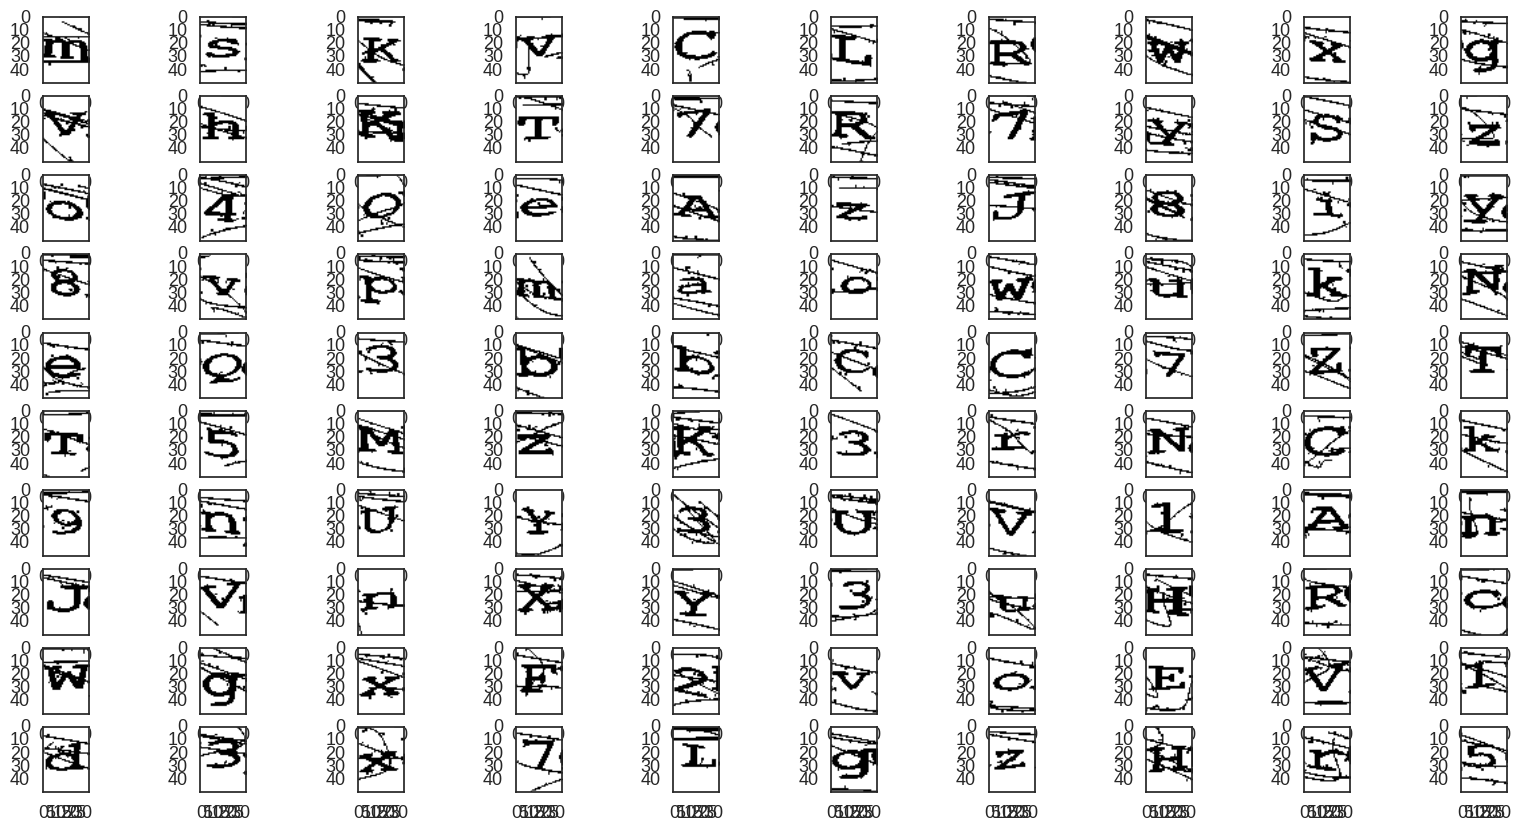

In [45]:
# 2º caractere

cropped = [get_char(img, 1) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [46]:
letters = ('m', 's', 'K', 'v', 'C', 'L', 'R', 'w', 'x', 'g',
          'v', 'h', 'K', 'T', '7', 'R', '7', 'Y', 'S', 'z',
          'o', '4', 'o', 'e', 'A', 'z', 'J', '8', 'i', 'y',
          '8', 'v', 'p', 'm', 'a', 'o', 'w', 'u', 'k', 'N',
          'e', 'Q', '3', 'b', 'b', 'c', 'C', '7', 'z', 'T',
          'T', '5', 'M', 'z', 'K', '3', 'r', 'N', 'C', 'k',
          '9', 'n', 'U', 'Y', '3', 'U', 'V', '1', 'A', 'n',
          'J', 'V', 'n', 'X', 'Y', '3', 'u', 'H', 'R', 'c',
          'W', 'g', 'x', 'F', '2', 'v', 'o', 'E', 'V', '1',
          'd', '3', 'x', '7', 'L', 'g', 'z', 'H', 'r', 's')

feed_char_dict(captcha_letters, letters, cropped)

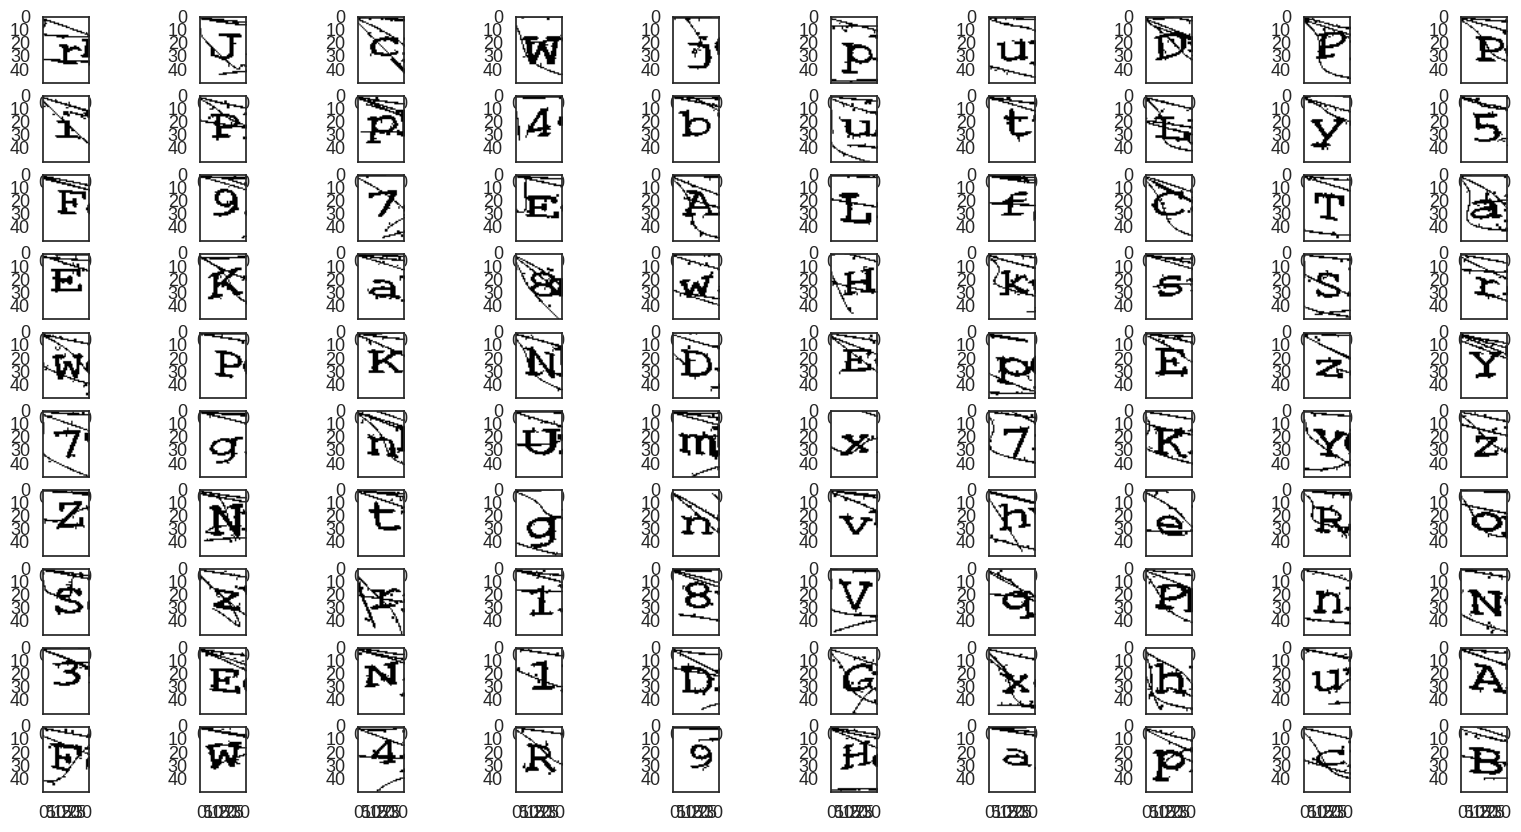

In [47]:
# 1º caractere
cropped = [get_char(img, 0) for img in unblobbed ]
plot_captchas( cropped, (10, 10) )

In [48]:
letters = ('r', 'J', 'c', 'W', 'j', 'p', 'u', 'D', 'P', 'P',
          'i', 'p', 'p', '4', 'b', 'u', 't', 'L', 'y', '5',
          'F', '9', '7', 'E', 'A', 'L', 'f', 'C', 'T', 'a',
          'E', 'K', 'a', '8', 'w', 'H', 'k', 's', 'S', 'r',
          'W', 'P', 'K', 'N', 'D', 'E', 'p', 'E', 'z', 'Y',
          '7', 'g', 'n', 'U', 'm', 'x', '7', 'K', 'Y', 'z',
          'Z', 'N', 't', 'g', 'n', 'v', 'h', 'e', 'R', 'o',
          'S', 'z', 'r', '1', '8', 'V', 'q', 'P', 'n', 'N',
          '3', 'E', 'N', '1', 'D', 'G', 'x', 'h', 'u', 'A',
          'F', 'w', '4', 'R', '9', 'H', 'a', 'p', 'c', 'B')

feed_char_dict(captcha_letters, letters, cropped)

# Salvar base de dados de Letras

In [49]:
save_images(captcha_letters)

------------------------------
# Gerar base de dados comparativa entre letras

Esta base deve ter os seguintes campos.

|RESPOSTA  | char1    | char2    | MSE_entre_c1_e_c2 | ISS_entre_c1_e_c2|
|:--------:|:--------:|:--------:|:-----------------:|:----------------:|
|      0   | character234.Png  | character121.Png   | 1456 | 0.556|
|	 1   | character411.Png  | character121.Png   | 1200 | 0.723|
|	 0   | character234.Png  | character121.Png   | 1456 | 0.556|
|	 0   | character234.Png  | character121.Png   | 1456              | 0.556|

Nesta base 30% das linhas devem ser de mesmos caracteres e MESMA CAIXA (maiuscula ou minusc). Se a linha tem os mesmos caracteres ainda que em posições e formatos diferentes
a variável resposta vai receber o VALOR 1. Caso sejam caracteres diferentes vai receber 0.
Linhas com letra q minutos e Q maiusculo vão receber zero!

In [50]:
letras, letters_dict = ler_letras("../letras.csv")
# retorna a permutação dois a dois da lista de arquivos de letras
letras_permutadas = list(itertools.permutations(letras, 2))

## Garatindo 30%


In [51]:
iguais, diferentes = checar_combinacoes(letras_permutadas, letters_dict)
print( "Temos {0} conjuntos iguais e {1} conjuntos com rótulos diferentes.".format(iguais,diferentes))
print( "A porcentagem atual é de: {0}".format( iguais/(iguais+diferentes) ))

Temos 8882.0 conjuntos iguais e 508798.0 conjuntos com rótulos diferentes.
A porcentagem atual é de: 0.017157317261628804


In [52]:
print( "Para garantir os 30% precisamos diminuir a quantidade de conjuntos, " + \
      "com rótulos diferentes, em {0}".format( round(diferentes - ((iguais / 0.3)-iguais)) ))

Para garantir os 30% precisamos diminuir a quantidade de conjuntos, com rótulos diferentes, em 488073


In [53]:
k = round(diferentes - ((iguais / 0.3)-iguais))
l = []
for i, permuta in enumerate(letras_permutadas):
    if k <= 0:
        break
    if (letters_dict[permuta[0]]['rotulo'] != letters_dict[permuta[1]]['rotulo']):
        l.append(i)
        k = k - 1
for index in sorted(l, reverse = True):
    del letras_permutadas[index]

In [61]:
iguais, diferentes = checar_combinacoes(letras_permutadas, letters_dict)
print( "Temos {0} conjuntos iguais e {1} conjuntos com rótulos diferentes. " + \
      "Total = {2}".format(iguais,diferentes, iguais + diferentes))
print( "A porcentagem atual é de: {0}%".format( round(iguais/(iguais+diferentes), 2)*100 ))

Temos {0} conjuntos iguais e {1} conjuntos com rótulos diferentes. Total = 29607.0
A porcentagem atual é de: 30.0%


## Gerando o arquivo de combinações

In [64]:
def save_combinations(permutes, dic):
    """ Função que recebe um conjunto de combinações de arquivos e um dicionário com os rótulos.
    O retorno desta função é a criação de um arquivo com as análises de combinações de cada
    combinação dor arquivos."""
    with open("../combinacoes.txt", 'w+') as f:
        f.write("resposta, char1, char2, MSE, ISS\n")
        
    for dupla in permutes:
        imgA = skio.imread("../" + dupla[0])
        imgB = skio.imread("../" + dupla[1])
        if (dic[dupla[0]]['rotulo'] == dic[dupla[1]]['rotulo']):
            resposta = 1
        else:
            resposta = 0
        m, s = comp_images(imgA, imgB)
        
        with open("../combinacoes.txt", 'a+') as f:
            f.write(str(resposta) + ", " + dupla[0] + ", " + dupla[1] + ", " + str(m) + ", " + str(s) + "\n")

In [63]:
%%capture
save_combinations(letras_permutadas, letters_dict)

---------------------------------
# Aplicação de comparação entre imagens

/home/rico/envs/py3/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/rico/envs/py3/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/rico/envs/py3/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/rico/envs/py3/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
 

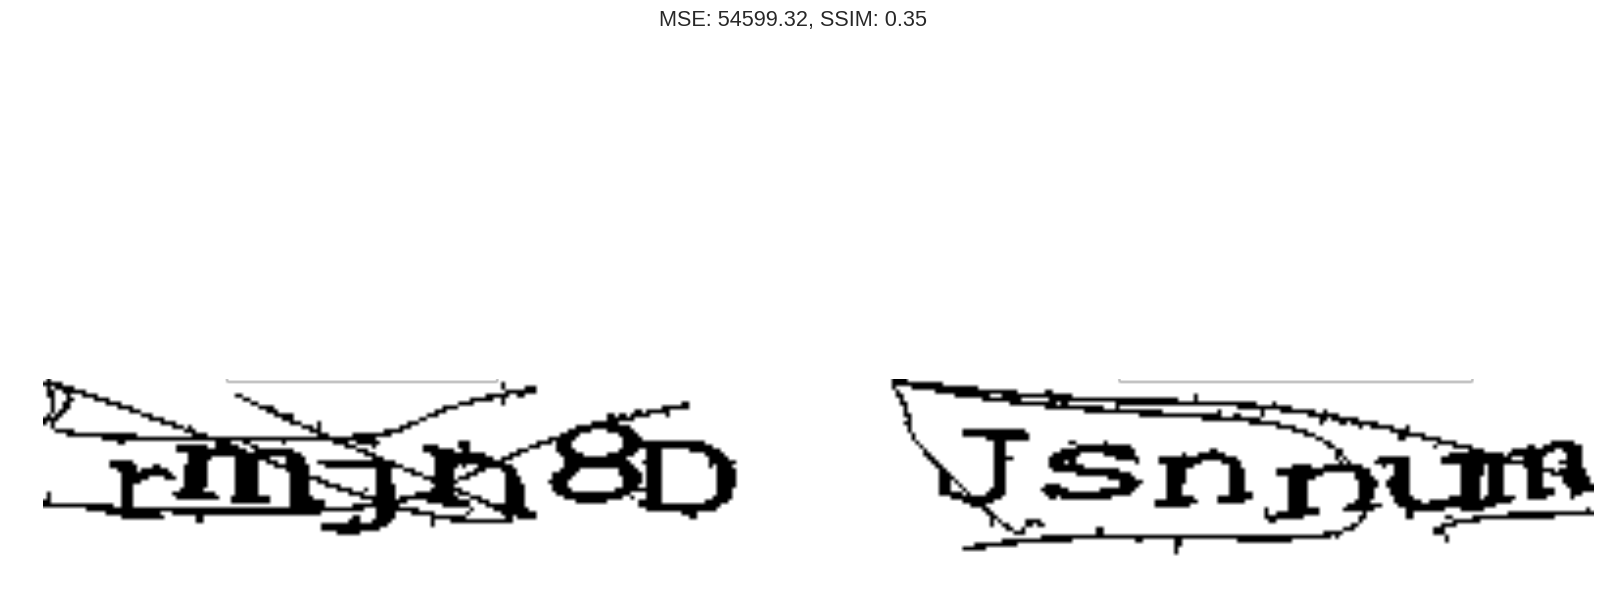

In [65]:
compare_images(unblobbed[0], unblobbed[1], "two captchas")

In [ ]:
compare_images(captcha_letters['w'][0], captcha_letters['w'][1], "two W's")

In [ ]:
compare_images(captcha_letters['9'][0], captcha_letters['9'][1], "two 9's")

In [ ]:
compare_images(captcha_letters['g'][0], captcha_letters['9'][1], "two differents")